### Loading and Visualizing the Jena weather dataset

In [1]:
import os
import csv
import numpy as np

data_dir = "D:\Bunny\Projects\Self\Temperature Forecast\Dataset\jena_climate_2009_2016"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
reader = csv.reader(f, delimiter = ',')

data = [row for row in reader]

header = data[0]
time_steps = []
series = []
#### Sampling data points on an hourly basis
for i, row in enumerate(data[1:]):
    if i%6 == 0:
        time_steps.append(row[0])
        series.append(row[1:])

time_steps = np.array(time_steps)
series = np.array(series).astype(np.float32)

In [2]:
print(header)
print("Shape of time steps tensor:", time_steps.shape)
print("Shape of the series tensor: ", series.shape)

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Shape of time steps tensor: (70076,)
Shape of the series tensor:  (70076, 14)


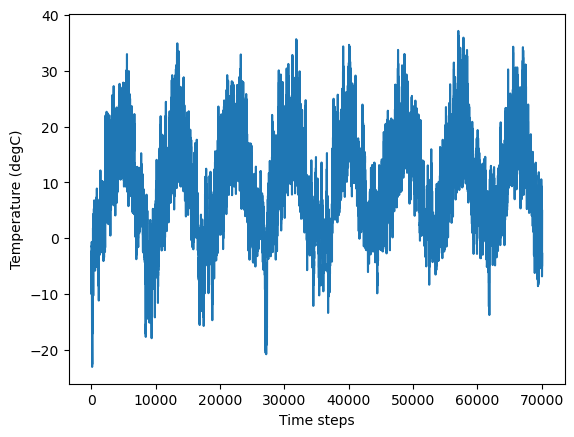

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

temp = [float(t) for t in series[:, 1]]

plt.plot(range(len(temp)), temp)
plt.xlabel("Time steps")
plt.ylabel("Temperature (degC)")

plt.show()
plt.clf()

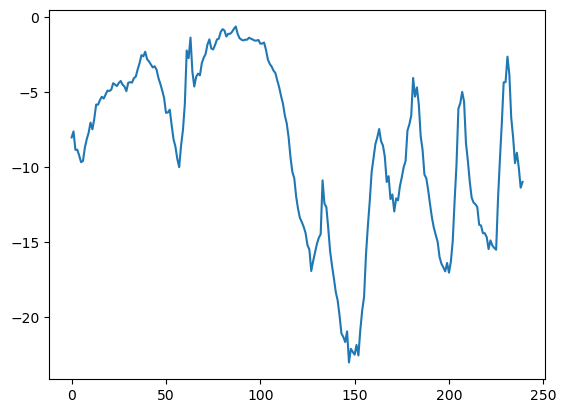

In [4]:
#### Plotting the first 10 days of temperature data

n_time_stamps = 240

plt.plot(range(n_time_stamps), temp[:n_time_stamps])

### Preparing the Data

In [5]:
lookback = 120    # Observations will go back 5 days
delay = 24    # Targets will be 24 hours in the future
batch_size = 32

In [6]:
from tensorflow.data import Dataset

def windowed_data(series, window_size, batch_size = batch_size):
    dataset = Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(window_size + delay, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + delay))
    
    dataset = dataset.map(lambda window: (window[:lookback], window[-1]))
    
    dataset = dataset.shuffle(100 * series.shape[0])
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
train_size = 42000
validation_size = 14000
test_size = series.shape[0] - train_size - validation_size

In [8]:
train_data = series[: train_size]
validation_data = series[train_size : (train_size + validation_size)]
test_data = series[(train_size + validation_size) :]

train_mean = train_data.mean(axis = 0)
train_std = train_data.std(axis = 0)

train_data -= train_mean
train_data /= train_std

validation_data -= train_mean
validation_data /= train_std

In [9]:
train_dataset = windowed_data(train_data, lookback)
validation_dataset = windowed_data(validation_data, lookback)

In [10]:
def numpying_dataset(dataset, series_size):
    n_batches = ((series_size - lookback) // batch_size) + 1
    features = np.empty(shape = (n_batches, batch_size, lookback, 14))
    labels = np.empty(shape = (n_batches, batch_size, 14))
    for i, batch in enumerate(dataset):
        if(batch[0].shape[0] == batch_size): # Because later while creating test dataset, found a batch[0] of size (13, 120, 14)
            features[i, :, :, :] = batch[0].numpy()
            labels[i, :, :] = batch[1].numpy()
    
    return features, labels

In [11]:
train_features, train_labels = numpying_dataset(train_dataset, train_size)
validation_features, validation_labels = numpying_dataset(validation_dataset, validation_size)

print("Shape of Training data features tensor:", train_features.shape)
print("Shape of Training data labels tensor:", train_labels.shape)
print("Shape of Validation data features tensor:", validation_features.shape)
print("Shape of Validation labels tensor:", validation_labels.shape)

Shape of Training data features tensor: (1309, 32, 120, 14)
Shape of Training data labels tensor: (1309, 32, 14)
Shape of Validation data features tensor: (434, 32, 120, 14)
Shape of Validation labels tensor: (434, 32, 14)


### Naive Approach: Setting a Baseline

In [12]:
def naive_approach(features, labels):
    predictions = np.empty(shape = labels.shape)
    for i, batch in enumerate(features):
        for j, window in enumerate(batch):
            predictions[i, j, :] = features[i, j, -1, :]
    
    return predictions

In [13]:
train_predictions_naive = naive_approach(train_features, train_labels)

train_base_mae = np.mean(np.mean(np.abs(train_predictions_naive - train_labels), axis = 0), axis = 0)
print("MAE on the training data using naive approach: \n", train_base_mae)

print()

train_base_mae_org_scale = train_base_mae * train_std
print("MAE on the training data using naive approach (on the original scale): \n", train_base_mae_org_scale)

print()

print("Training data std: \n", train_std)

print()

overall_naive_train_mae = np.mean(train_base_mae_org_scale)
print("Overall MAE for Training data using naive approach (on the original scale):", overall_naive_train_mae)

MAE on the training data using naive approach: 
 [0.54376677 0.29694719 0.31316001 0.33788957 0.6016918  0.30314439
 0.35490834 0.40344493 0.35854726 0.3584305  0.35438222 0.85009855
 0.81707717 0.82892557]

MAE on the training data using naive approach (on the original scale): 
 [ 4.51989323  2.6254068   2.78851183  2.42008762  9.96707553  2.35236775
  1.50739664  1.94941463  0.96620655  1.54057319 14.80111515  1.29393812
  1.87958603 73.12742905]

Training data std: 
 [ 8.312191   8.841326   8.904431   7.1623626 16.565084   7.759892
  4.2472844  4.8319225  2.6947815  4.2981086 41.765965   1.5221037
  2.3003776 88.219536 ]

Overall MAE for Training data using naive approach (on the original scale): 8.695643008028897


In [14]:
validation_predictions_naive = naive_approach(validation_features, validation_labels)

val_base_mae = np.mean(np.mean(np.abs(validation_predictions_naive - validation_labels), axis = 0), axis = 0)
print("MAE on the validation data using naive approach: \n", val_base_mae)

print()

val_base_mae_org_scale = val_base_mae * train_std
print("MAE on the validation data using naive approach (on the original scale): \n", val_base_mae_org_scale)

print()

overall_naive_val_mae = np.mean(val_base_mae_org_scale)
print("Overall MAE for validation data using naive approach (on the original scale):", overall_naive_val_mae)

MAE on the validation data using naive approach: 
 [0.58117389 0.29017944 0.30397352 0.3047761  0.60210594 0.28328214
 0.32160052 0.37721199 0.32397192 0.3239509  0.34421924 0.85927673
 0.82421976 0.81775772]

MAE on the validation data using naive approach (on the original scale): 
 [ 4.83082841  2.565571    2.70671137  2.18291691  9.97393579  2.19823877
  1.36592886  1.82265913  0.87303355  1.39237616 14.37664854  1.30790826
  1.89601668 72.14220638]

Overall MAE for validation data using naive approach (on the original scale): 8.545355701163901


### Basic Machine Learning approach: Regression

In [15]:
from keras.models import Sequential
from keras import layers

basic_model = Sequential()
basic_model.add(layers.Flatten(input_shape = (lookback, 14)))
basic_model.add(layers.Dense(32, activation = 'relu'))
basic_model.add(layers.Dense(14))

basic_model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mae'])
history = basic_model.fit(train_dataset, epochs = 20, validation_data = validation_dataset)

Epoch 1/20
1309/1309 [==============================] - 29s 8ms/step - loss: 0.5346 - mae: 0.5333 - val_loss: 0.3990 - val_mae: 0.4487
Epoch 2/20
1309/1309 [==============================] - 25s 7ms/step - loss: 0.3742 - mae: 0.4383 - val_loss: 0.3878 - val_mae: 0.4369
Epoch 3/20
1309/1309 [==============================] - 42s 15ms/step - loss: 0.3547 - mae: 0.4237 - val_loss: 0.4004 - val_mae: 0.4618
Epoch 4/20
1309/1309 [==============================] - 50s 13ms/step - loss: 0.3448 - mae: 0.4173 - val_loss: 0.4076 - val_mae: 0.4546
Epoch 5/20
1309/1309 [==============================] - 43s 14ms/step - loss: 0.3387 - mae: 0.4131 - val_loss: 0.3867 - val_mae: 0.4413
Epoch 6/20
1309/1309 [==============================] - 50s 14ms/step - loss: 0.3339 - mae: 0.4095 - val_loss: 0.4016 - val_mae: 0.4515
Epoch 7/20
1309/1309 [==============================] - 50s 14ms/step - loss: 0.3307 - mae: 0.4077 - val_loss: 0.3847 - val_mae: 0.4403
Epoch 8/20
1309/1309 [============================

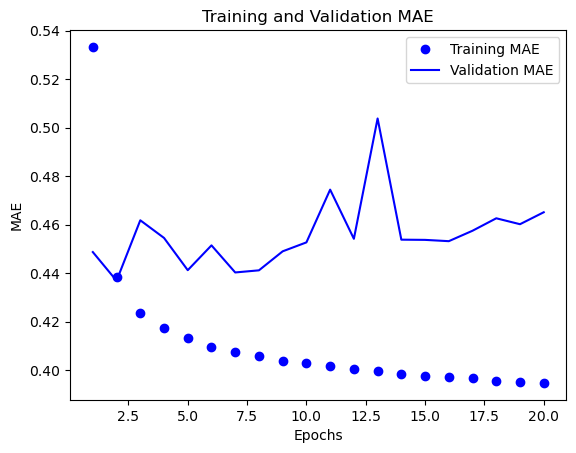

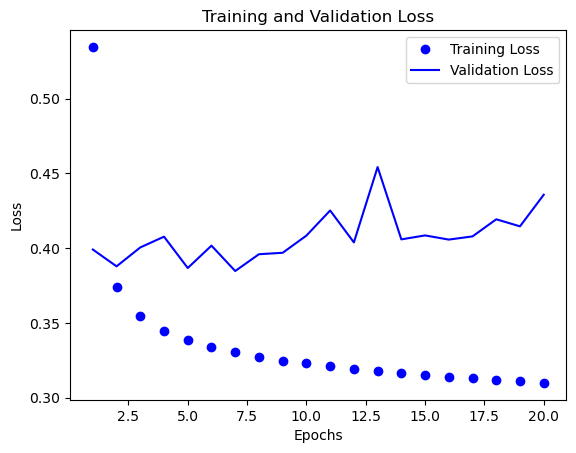

<Figure size 640x480 with 0 Axes>

In [16]:
#### Plotting the results

import matplotlib.pyplot as plt

epochs = range(1, 21)

plt.plot(epochs, history.history['mae'], 'bo', label = 'Training MAE')
plt.plot(epochs, history.history['val_mae'], 'b', label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label = 'Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()
plt.clf()

In [17]:
def debatch_labels(dataset, series_size):
    length = series_size - lookback - delay + 1
    debatch = np.empty(shape = (length, 14))
    for i, batch in enumerate(dataset):
        for j, window in enumerate(batch[1]):
            debatch[i + j, :] = window
            
    return debatch

debatch_train_labels = debatch_labels(train_dataset, train_size)
debatch_val_labels = debatch_labels(validation_dataset, validation_size)

In [18]:
train_predictions_regr = basic_model.predict(train_dataset)

print()
train_mae_regr = np.mean(np.abs(train_predictions_regr - debatch_train_labels), axis = 0)
print("MAE on the Training data using Regression approach: \n", train_mae_regr)

print()

train_mae_regr_org_scale = train_mae_regr * train_std
print("MAE on the Training data using Regression approach (on the original scale): \n", train_mae_regr_org_scale)

print()

overall_regr_train_mae = np.mean(train_mae_regr_org_scale)
print("Overall Training data MAE using Regression approach (on the original scale):", overall_regr_train_mae)
print("Overall Training data MAE using Naive approach (on the original scale):", overall_naive_train_mae)

1309/1309 [==============================] - 14s 2ms/step

MAE on the Training data using Regression approach: 
 [0.76247212 0.77895266 0.7278679  0.77737224 0.63901242 0.71141653
 0.7606167  0.59280309 0.752664   0.75295419 0.61730737 0.49059481
 0.53917101 0.41110969]

MAE on the Training data using Regression approach (on the original scale): 
 [ 6.3378139   6.88697426  6.48124976  5.56782186 10.58529464  5.52051546
  3.23055543  2.8643786   2.02826507  3.23627886 25.78243757  0.74673617
  1.24029693 36.26790568]

Overall Training data MAE using Regression approach (on the original scale): 8.341180298124993
Overall Training data MAE using Naive approach (on the original scale): 8.695643008028897


In [19]:
validation_predictions_regr = basic_model.predict(validation_dataset)

print()
validation_mae_regr = np.mean(np.abs(validation_predictions_regr - debatch_val_labels), axis = 0)
print("MAE on the Validation data using Regression approach: \n", validation_mae_regr)

print()

validation_mae_regr_org_scale = validation_mae_regr * train_std
print("MAE on the Validation data using Regression approach (on the original scale): \n", validation_mae_regr_org_scale)

print()

overall_regr_val_mae = np.mean(validation_mae_regr_org_scale)
print("Overall Validation data MAE using Regression approach (on the original scale):", overall_regr_val_mae)
print("Overall Validation data MAE using Naive approach (on the original scale):", overall_naive_val_mae)

434/434 [==============================] - 5s 1ms/step

MAE on the Validation data using Regression approach: 
 [0.71072777 0.65917694 0.61722493 0.66385864 0.61545261 0.6166751
 0.68168053 0.53343329 0.67590279 0.67596446 0.54119427 0.47229347
 0.51780085 0.39482227]

MAE on the Validation data using Regression approach (on the original scale): 
 [ 5.90770498  5.82799806  5.49603701  4.75479627 10.19502448  4.78533217
  2.89529107  2.57750831  1.82141035  2.90536865 22.60350076  0.71887962
  1.19113748 34.8310373 ]

Overall Validation data MAE using Regression approach (on the original scale): 7.60793046439036
Overall Validation data MAE using Naive approach (on the original scale): 8.545355701163901


### RNN

In [20]:
model1 = Sequential()
model1.add(layers.GRU(32, input_shape = (lookback, 14)))
model1.add(layers.Dense(32, activation = 'relu'))
model1.add(layers.Dense(14))

model1.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mae'])

history1 = model1.fit(train_dataset, epochs = 20, validation_data = validation_dataset)

Epoch 1/20
1309/1309 [==============================] - 77s 49ms/step - loss: 0.3896 - mae: 0.4448 - val_loss: 0.3683 - val_mae: 0.4267
Epoch 2/20
1309/1309 [==============================] - 80s 52ms/step - loss: 0.3578 - mae: 0.4217 - val_loss: 0.3730 - val_mae: 0.4340
Epoch 3/20
1309/1309 [==============================] - 80s 53ms/step - loss: 0.3496 - mae: 0.4155 - val_loss: 0.3745 - val_mae: 0.4321
Epoch 4/20
1309/1309 [==============================] - 85s 57ms/step - loss: 0.3430 - mae: 0.4105 - val_loss: 0.3611 - val_mae: 0.4215
Epoch 5/20
1309/1309 [==============================] - 83s 55ms/step - loss: 0.3380 - mae: 0.4071 - val_loss: 0.3587 - val_mae: 0.4212
Epoch 6/20
1309/1309 [==============================] - 77s 50ms/step - loss: 0.3338 - mae: 0.4039 - val_loss: 0.3600 - val_mae: 0.4206
Epoch 7/20
1309/1309 [==============================] - 80s 54ms/step - loss: 0.3293 - mae: 0.4009 - val_loss: 0.3683 - val_mae: 0.4301
Epoch 8/20
1309/1309 [==========================

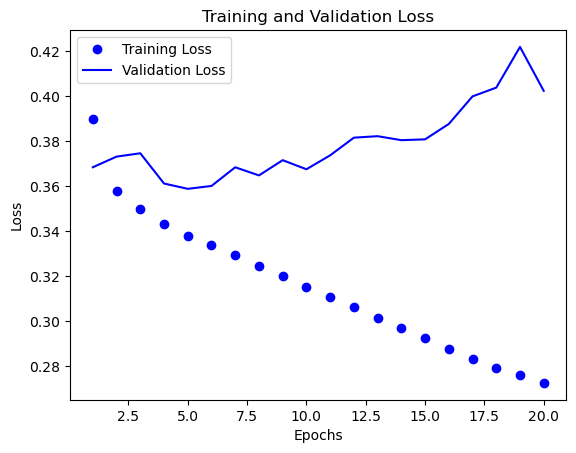

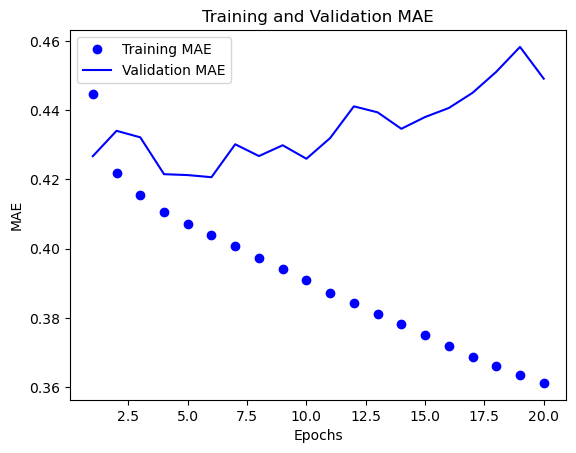

<Figure size 640x480 with 0 Axes>

In [21]:
#### Plotting the results

epochs = range(1, 21)

plt.plot(epochs, history1.history['loss'], 'bo', label = 'Training Loss')
plt.plot(epochs, history1.history['val_loss'], 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs, history1.history['mae'], 'bo', label = 'Training MAE')
plt.plot(epochs, history1.history['val_mae'], 'b', label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.show()
plt.clf()

In [22]:
rnn_train_pred = model1.predict(train_dataset)

rnn_train_mae = np.mean(np.abs(rnn_train_pred - debatch_train_labels), axis = 0)
print("Training data MAE using RNN: \n", rnn_train_mae)

print()

rnn_train_mae_org_scale = rnn_train_mae * train_std
print("Training data MAE using RNN (on original scale): \n", rnn_train_mae_org_scale)

print()

overall_rnn_train_mae = np.mean(rnn_train_mae_org_scale)
print("Overall Training data MAE using RNN (on original scale):", overall_rnn_train_mae)
print("Overall Training data MAE using Regression approach (on the original scale):", overall_regr_train_mae)
print("Overall Training data MAE using Naive approach (on the original scale):", overall_naive_train_mae)

1309/1309 [==============================] - 25s 12ms/step
Training data MAE using RNN: 
 [0.62582742 0.81592257 0.8115079  0.80399445 0.66136858 0.78345237
 0.81905756 0.67384878 0.81834551 0.81821573 0.79282322 0.47551455
 0.5105661  0.36708291]

Training data MAE using RNN (on original scale): 
 [ 5.20199703  7.21383726  7.22601639  5.75849973 10.95562632  6.07950576
  3.47877042  3.25598508  2.20526236  3.51678005 33.11302643  0.72378244
  1.17449483 32.38388399]

Overall Training data MAE using RNN (on original scale): 8.734819149283615
Overall Training data MAE using Regression approach (on the original scale): 8.341180298124993
Overall Training data MAE using Naive approach (on the original scale): 8.695643008028897


In [23]:
rnn_val_pred = model1.predict(validation_dataset)

rnn_val_mae = np.mean(np.abs(rnn_val_pred - debatch_val_labels), axis = 0)
print("Validation data MAE using RNN: \n", rnn_val_mae)

print()

rnn_val_mae_org_scale = rnn_val_mae * train_std
print("Validation data MAE using RNN (on original scale): \n", rnn_val_mae_org_scale)

print()

overall_rnn_val_mae = np.mean(rnn_val_mae_org_scale)
print("Overall Validation data MAE using RNN (on original scale):", overall_rnn_val_mae)
print("Overall Validation data MAE using Regression approach (on the original scale):", overall_regr_val_mae)
print("Overall Validation data MAE using Naive approach (on the original scale):", overall_naive_val_mae)

434/434 [==============================] - 9s 12ms/step
Validation data MAE using RNN: 
 [0.62293062 0.66131784 0.66432934 0.63696638 0.631419   0.66349839
 0.69474993 0.59051066 0.69572802 0.69530222 0.66780057 0.4874951
 0.52181238 0.34847789]

Validation data MAE using RNN (on original scale): 
 [ 5.17791833  5.84692642  5.91547499  4.56218416 10.45950899  5.14867585
  2.95080054  2.85330174  1.87483501  2.98848443 27.8913349   0.74201808
  1.20036552 30.74255749]

Overall Validation data MAE using RNN (on original scale): 7.739599032157099
Overall Validation data MAE using Regression approach (on the original scale): 7.60793046439036
Overall Validation data MAE using Naive approach (on the original scale): 8.545355701163901


### Regularization using Dropouts

In [24]:
model2 = Sequential()
model2.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.5, return_sequences = True, input_shape = (lookback, 14)))
model2.add(layers.GRU(64, dropout = 0.1, recurrent_dropout = 0.5, activation = 'relu'))
model2.add(layers.Dense(32, activation = 'relu'))
model2.add(layers.Dense(14, activation = 'relu'))

model2.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mae'])

history2 = model2.fit(train_dataset, epochs = 30, validation_data = validation_dataset)

Epoch 1/30
1309/1309 [==============================] - 271s 197ms/step - loss: 0.7376 - mae: 0.6762 - val_loss: 0.6162 - val_mae: 0.6237
Epoch 2/30
1309/1309 [==============================] - 246s 179ms/step - loss: 0.7242 - mae: 0.6676 - val_loss: 0.6098 - val_mae: 0.6209
Epoch 3/30
1309/1309 [==============================] - 250s 184ms/step - loss: 0.7212 - mae: 0.6655 - val_loss: 0.6081 - val_mae: 0.6192
Epoch 4/30
1309/1309 [==============================] - 248s 182ms/step - loss: 0.7182 - mae: 0.6637 - val_loss: 0.6186 - val_mae: 0.6248
Epoch 5/30
1309/1309 [==============================] - 256s 189ms/step - loss: 0.7155 - mae: 0.6622 - val_loss: 0.6151 - val_mae: 0.6243
Epoch 6/30
1309/1309 [==============================] - 253s 185ms/step - loss: 0.7125 - mae: 0.6604 - val_loss: 0.6155 - val_mae: 0.6208
Epoch 7/30
1309/1309 [==============================] - 270s 199ms/step - loss: 0.7090 - mae: 0.6585 - val_loss: 0.6123 - val_mae: 0.6206
Epoch 8/30
1309/1309 [============

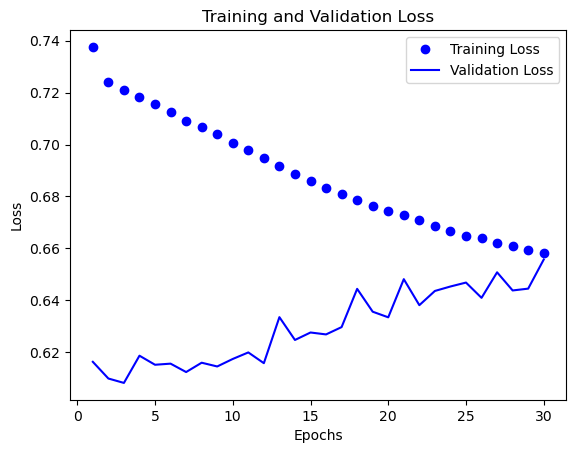

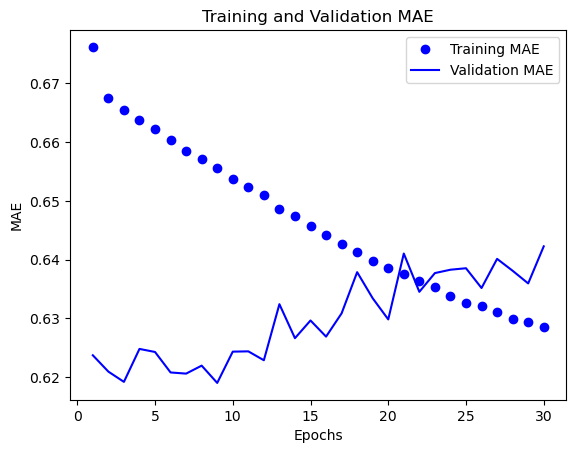

<Figure size 640x480 with 0 Axes>

In [25]:
### Plotting the results

epochs = range(1, 31)

plt.plot(epochs, history2.history['loss'], 'bo', label = 'Training Loss')
plt.plot(epochs, history2.history['val_loss'], 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs, history2.history['mae'], 'bo', label = 'Training MAE')
plt.plot(epochs, history2.history['val_mae'], 'b', label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.show()
plt.clf()

In [26]:
reg_rnn_train_pred = model2.predict(train_dataset)

reg_rnn_train_mae = np.mean(np.abs(reg_rnn_train_pred - debatch_train_labels), axis = 0)
print("Training data MAE using Regularized RNN: \n", reg_rnn_train_mae)

print()

reg_rnn_train_mae_org_scale = reg_rnn_train_mae * train_std
print("Training data MAE using Regularized RNN (on original scale): \n", reg_rnn_train_mae_org_scale)

print()

overall_reg_rnn_train_mae = np.mean(reg_rnn_train_mae)
print("Overall Training data MAE using Regularized RNN:", overall_reg_rnn_train_mae)
print("Overall Training data MAE using RNN (on original scale):", overall_rnn_train_mae)
print("Overall Training data MAE using Regression approach (on the original scale):", overall_regr_train_mae)
print("Overall Training data MAE using Naive approach (on the original scale):", overall_naive_train_mae)

1309/1309 [==============================] - 54s 33ms/step
Training data MAE using Regularized RNN: 
 [0.35816834 0.43292786 0.02623685 0.02626807 0.2968043  0.40563733
 0.42247872 0.35362934 0.42145553 0.42104499 0.38274256 0.22616314
 0.24704565 0.19276486]

Training data MAE using Regularized RNN (on original scale): 
 [ 2.97716368  3.82765626  0.23362421  0.18814147  4.91658837  3.14770186
  1.79438728  1.70870958  1.13573059  1.80969708 15.98561211  0.34424374
  0.56829828 17.00562632]

Overall Training data MAE using Regularized RNN: 0.3009548246905705
Overall Training data MAE using RNN (on original scale): 8.734819149283615
Overall Training data MAE using Regression approach (on the original scale): 8.341180298124993
Overall Training data MAE using Naive approach (on the original scale): 8.695643008028897


In [27]:
reg_rnn_val_pred = model2.predict(validation_dataset)

reg_rnn_val_mae = np.mean(np.abs(reg_rnn_val_pred - debatch_val_labels), axis = 0)
print("Validation data MAE using Regularized RNN: \n", reg_rnn_val_mae)

print()

reg_rnn_val_mae_org_scale = reg_rnn_val_mae * train_std
print("Validation data MAE using Regularized RNN (on original scale): \n", reg_rnn_val_mae_org_scale)

print()

overall_reg_rnn_val_mae = np.mean(reg_rnn_val_mae)
print("Overall Validation data MAE using Regularized RNN:", overall_reg_rnn_val_mae)
print("Overall Validation data MAE using RNN (on original scale):", overall_rnn_val_mae)
print("Overall Validation data MAE using Regression approach (on the original scale):", overall_regr_val_mae)
print("Overall Validation data MAE using Naive approach (on the original scale):", overall_naive_val_mae)

434/434 [==============================] - 18s 34ms/step
Validation data MAE using Regularized RNN: 
 [0.36165181 0.33949882 0.02250247 0.02262638 0.28219151 0.29386978
 0.31608226 0.26249795 0.31538693 0.31507516 0.30783967 0.1935383
 0.21679841 0.19962493]

Validation data MAE using Regularized RNN (on original scale): 
 [ 3.00611893  3.0016197   0.20037171  0.16205832  4.67452611  2.28039777
  1.34249124  1.26836974  0.84989888  1.35422725 12.85722076  0.29458536
  0.49871821 17.61081869]

Overall Validation data MAE using Regularized RNN: 0.24637031313979194
Overall Validation data MAE using RNN (on original scale): 7.739599032157099
Overall Validation data MAE using Regression approach (on the original scale): 7.60793046439036
Overall Validation data MAE using Naive approach (on the original scale): 8.545355701163901


### Evaluating on the Test data

In [28]:
test_data -= train_mean
test_data /= train_std

In [29]:
test_dataset = windowed_data(test_data, lookback)

In [30]:
test_features, test_labels = numpying_dataset(test_dataset, test_size)
debatch_test_labels = debatch_labels(test_dataset, test_size)

print("Shape of Test features tensor:", test_features.shape)
print("Shape of Test labels tensor:", test_labels.shape)

Shape of Test features tensor: (437, 32, 120, 14)
Shape of Test labels tensor: (437, 32, 14)


In [31]:
test_pred_naive = naive_approach(test_features, test_labels)

test_mae_naive = np.mean(np.mean(np.abs(test_pred_naive - test_labels), axis = 0), axis = 0)
test_mae_naive_org_scale = test_mae_naive * train_std
overall_test_mae_naive = np.mean(test_mae_naive_org_scale)

print("MAE on the test data using naive approach (on original scale): \n", test_mae_naive_org_scale)
print()
print("Overall MAE on the Test data using naive approach:", overall_test_mae_naive)

MAE on the test data using naive approach (on original scale): 
 [ 4.23436346  2.58329735  2.72797196  2.26397168 10.08422914  2.63376502
  1.58006651  2.26213816  1.01110483  1.61106764 14.12152492  1.28287328
  1.88029031 73.02951084]

Overall MAE on the Test data using naive approach: 8.66472679239486


In [32]:
test_pred_regr = basic_model.predict(test_dataset)

print()

test_mae_regr = np.mean(np.abs(test_pred_regr - debatch_test_labels), axis = 0)
test_mae_regr_org_scale = test_mae_regr * train_std
overall_test_mae_regr = np.mean(test_mae_regr_org_scale)

print("MAE on the test data using Regression (on original scale): \n", test_mae_regr_org_scale)
print()
print("Overall MAE on the Test data using Regression:", overall_test_mae_regr)

436/436 [==============================] - 4s 2ms/step

MAE on the test data using Regression (on original scale): 
 [ 5.95849147  6.16957882  5.90128971  4.85412567 10.4143338   5.48033805
  3.03895708  3.03721289  1.91114029  3.04754194 24.65088618  0.70569901
  1.1801048  34.00937323]

Overall MAE on the Test data using Regression: 7.8827909259116415


In [33]:
test_pred_m1 = model1.predict(test_dataset)

print()

test_mae_m1 = np.mean(np.abs(test_pred_m1 - debatch_test_labels), axis = 0)
test_mae_m1_org_scale = test_mae_m1 * train_std
overall_test_mae_m1 = np.mean(test_mae_m1_org_scale)

print("MAE on the test data using RNN (on original scale): \n", test_mae_m1_org_scale)
print()
print("Overall MAE on the Test data using RNN:", overall_test_mae_m1)

436/436 [==============================] - 9s 13ms/step

MAE on the test data using RNN (on original scale): 
 [ 5.029573    6.64658907  6.69564155  5.18788858 10.7090712   6.22997569
  3.38501721  3.45076667  2.14892848  3.4239372  30.77496466  0.77375768
  1.25914231 30.11638469]

Overall MAE on the Test data using RNN: 8.273688429413616


In [34]:
test_pred_m2 = model2.predict(test_dataset)

print()

test_mae_m2 = np.mean(np.abs(test_pred_m2 - debatch_test_labels), axis = 0)
test_mae_m2_org_scale = test_mae_m2 * train_std
overall_test_mae_m2 = np.mean(test_mae_m2_org_scale)

print("MAE on the test data using Regularized RNN (on original scale): \n", test_mae_m2_org_scale)
print()
print("Overall MAE on the Test data using Regularized RNN:", overall_test_mae_m2)

436/436 [==============================] - 18s 32ms/step

MAE on the test data using Regularized RNN (on original scale): 
 [ 3.21673003  4.6839888   0.22778985  0.17955102  4.27366347  4.02340582
  2.20220947  2.12374025  1.39092885  2.21636137 10.77778405  0.32238888
  0.5525492  17.32682383]

Overall MAE on the Test data using Regularized RNN: 3.8227082062711597


In [37]:
print("Train std: \n", train_std)
print()
print()
print("Overall MAE on Test data:")
print()
print("Naive Forecasting:", overall_test_mae_naive)
print("Regression:", overall_test_mae_regr)
print("RNN:", overall_test_mae_m1)
print("Regularized RNN:", overall_test_mae_m2)

Train std: 
 [ 8.312191   8.841326   8.904431   7.1623626 16.565084   7.759892
  4.2472844  4.8319225  2.6947815  4.2981086 41.765965   1.5221037
  2.3003776 88.219536 ]


Overall MAE on Test data:

Naive Forecasting: 8.66472679239486
Regression: 7.8827909259116415
RNN: 8.273688429413616
Regularized RNN: 3.8227082062711597


## Model 2 (Regularized RNN) is the best